In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook
import datetime
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm
import warnings
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
#한글 깨짐방지
plt.rc('font',family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [13]:
path = './data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission  = pd.read_csv(path + 'submission.csv')
merge_df = pd.concat([train,test])

In [14]:
train.shape, test.shape

((3362796, 8), (473392, 8))

In [15]:
test['date'] = pd.to_datetime(test['date'])
gap_check = test.groupby('store_id')['date'].agg(['min','max'])
gap = (gap_check['max']-gap_check['min']).apply(lambda x : x.days)
print(f'test의 최소 길이: {gap.min()},test의 최대길이 : {gap.max()}')

test의 최소 길이: 93,test의 최대길이 : 607


### Data setting
* 거래 취소의 경우 거래금액, 환불금액 2회 체크되므로 거래취소 횟수 만큼 제외
* 날짜기준으로 묶어줄 필요가 있음
* 주말과 요일은 날짜기준으로 결합

-> 시간은 EDA에서 상세히 다시살펴볼것 (새벽시간대 매출이 높은 곳이라던지)

### 필요없는 row 제거
* 2nd 솔루션 : 거래기록이 160일 이하인 경우/ 2018-07-31 주변 5일 내 거래가 없으면 제외, 
    * test의 경우 2019-03-31 이전 7일간 거래가 없으면 폐업으로 추정
* 변경 : 거래기록 100일 이하인경우 삭제, 거래횟수가 30회 이하면 제외

In [16]:
# train 중 전체 거래일이 100일 이하인경우 학습에 사용불가
train['date'] = pd.to_datetime(train['date'])
gap_check = train.groupby('store_id')['date'].agg(['min','max'])
gap = (gap_check['max']-gap_check['min']).apply(lambda x : x.days)
gap.name = 'gap'
row_count = train.groupby('store_id')['date'].count()
gap = pd.concat([gap,row_count],axis=1)

del_id = gap.loc[(gap['gap']<100)|(gap['date']<29)].index
clean_train = train[~(train.store_id.isin(del_id))]

In [17]:
print(f'기본 트레인 길이 : {train.shape[0]}, 기본트레인 상점수 : {train.store_id.nunique()}')
print(f'clean 트레인 길이 : {clean_train.shape[0]}, clean 트레인 상점수 : {clean_train.store_id.nunique()}')
print(f'길이 차이 : {train.shape[0] - clean_train.shape[0]},상점수 차이 : {train.store_id.nunique() - clean_train.store_id.nunique()}')

기본 트레인 길이 : 3362796, 기본트레인 상점수 : 1775
clean 트레인 길이 : 3343266, clean 트레인 상점수 : 1483
길이 차이 : 19530,상점수 차이 : 292


In [18]:
#전체날짜의 휴일 요일
all_dates = merge_df.drop_duplicates('date').sort_values('date')
all_dates = all_dates[['date','days_of_week','holyday']]
all_dates.reset_index(drop=True, inplace=True)
all_dates['date'] = pd.to_datetime(all_dates['date'])

In [20]:
#환불금액이 동일하지 않은 경우도 있음 
train.loc[(train.store_id == 176)&(train.date == datetime.datetime(2018,7,13))]

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
486173,176,2018-07-13,13:34:02,edba13c668,-2700,18.0,4,0
486174,176,2018-07-13,16:30:12,77fff27956,2750,NaN,4,0


In [51]:
def reform_data(df, isTrain = True):
    '''날짜별로 나열되어있는 데이터를 상정별로 병합
    
    데이터를 store_id를 기준으로 병합. 최종 거래일로 부터 100일인 날짜를 마지막으로 설정 후
    최초 거래일자부터의 데이터를 결합. 마지막 100일의 거래금액은 y로 변환
    
    all_dates는 train,test의 날짜를 결합해놓은 데이터 
    
    추가되는 feature
    amount_mean, amount_mid : 전체 거래금액 평균 및 중앙값
    count_sum, count_mean : 전체 거래횟수 및 평균 거래횟수
    refund_count, refund_rate : 전체 환불횟수 및 환불비율
    daily_trans_amount : 일별 평균 거래금액
    mean_gap : 다음날짜까지의 거래기간의 평균
    0~6_sum, 0~6_mean : 요일별 전체 거래금액 및 평균 거래금액
    unholy, holy_mean, sum : 평일/주말 평균 거래 금액 및 전체 거래금액
    7D,15D,30D_sum, median, mean : 마지막 날짜에서 7,15,30일간 거래금액
    7,15,30D_MA7_mean : 마지막 날짜에서 7,15,30일간 7일간 이동평균
    7,15,30D_MA15_mean : 마지막 날짜에서 7,15,30일간 15일간 이동평균
    7,15,30D_MA30_mean : 마지막 날짜에서 7,15,30일간 30일간 이동평균
    
    Parameters
    ---------
    df(DataFrame) : train, test 데이터 입력
    isTrain(bool) : train일때 True, test일때, False
    
    '''
    df.loc[df.amount <0,'refund'] = 1
    sample_df = df.groupby(['date','store_id']).agg({'amount':['sum','count'],'refund':'sum'}).reset_index()
    sample_df.columns = ['date','store_id','amount_sum','amount_count','refund_sum']
    sample_df['date'] = pd.to_datetime(sample_df['date'])
    sample_df['temp_date'] = sample_df['date']

    #거래횟수당 평균 거래금액 
    sample_df['trans_amount'] = sample_df['amount_sum']/(sample_df['amount_count']-sample_df['refund_sum'])
    sample_df['trans_amount'].fillna(0,inplace= True)

    #날짜병합
    sample_df = pd.merge(sample_df,all_dates)

    sample_df.set_index("date",inplace=True)

    store_id_list = sample_df.store_id.unique()
    fin_ls =[]
    add_row = pd.DataFrame({'holyday_amount_sum':0,'holyday_amount_mean':0},index = ['holy']) #holyday 없는경우 
    
    for store_id in notebook.tqdm(store_id_list):

        store = sample_df[sample_df.store_id == store_id]    
        store = store.asfreq('D',fill_value = 0) #일자별로 열추가 
        store['temp_date'] = store.index
        store['store_id'] = store_id

        # 7일, 15일, 30일간의 이동평균 계산 
        store['MA7'] = store['amount_sum'].rolling('7D').mean()
        store['MA15'] = store['amount_sum'].rolling('15D').mean()
        store['MA30'] = store['amount_sum'].rolling('30D').mean()

        # train set인 경우 마지막 100일은 y값으로 저장되어야함
        # store_x는 100일전까지 기간 데이터 
        if isTrain:
            store_y = store.last("100D")
            y = store_y.amount_sum.sum()
            store_x = store[store.temp_date < store_y.iloc[0].temp_date]
        #test는 전체
        else : 
            y = 0
            store_x = store[:]

        feat = dict()

        #amount >0 이상인 경우만 
        over_zero = store_x.loc[store_x.amount_sum>0]
        
        # base (거래가 있는 경우만 )
        feat['store_id'] = store_id
        feat['y'] = y
        feat['amount_mean'] = over_zero.amount_sum.mean()  # 거래액의 평균
        feat['amount_mid'] = over_zero.amount_sum.median() # 거래액의 중간값
        feat['count_sum'] = over_zero.amount_count.sum() # 전체 거래 횟수
        feat['count_mean'] = over_zero.amount_count.mean() # 평균 거래 횟수
        feat['refund_count'] = over_zero.refund_sum.sum() # 전체 최소 횟수
        feat['refund_rate'] = over_zero['refund_sum'].sum()/over_zero.shape[0] # 취소율
        feat['daily_trans_amount'] = over_zero.trans_amount.sum() / over_zero.shape[0] #일자별 평균 금액의 평균

        feat['mean_gap'] = (over_zero.index[1:] - over_zero.index[:-1]).days.values.mean() # 거래일자간 평균 기간
        
        #weekly (거래가 있는 경우만 고려)
        weekly = over_zero[['days_of_week','amount_sum']].groupby('days_of_week').agg(['sum','mean'])
        weekly.columns = ['weekly_amount_sum','weekly_amount_mean']

        weekly_sum = weekly['weekly_amount_sum']
        weekly_sum.index = [f"{index}_sum" for index in weekly['weekly_amount_sum'].index.values]
        feat.update(weekly_sum.to_dict())

        weekly_mean = weekly['weekly_amount_mean']
        weekly_mean.index = [f"{index}_mean" for index in weekly['weekly_amount_mean'].index.values]
        feat.update(weekly_mean.to_dict())

        #holyday (거래가 있는 경우만 고려)
        holyday = over_zero[['holyday','amount_sum']].groupby('holyday').agg(['sum','mean'])
        holyday.columns = ['holyday_amount_sum','holyday_amount_mean']

        try : 
            holyday.index = ['unholy','holy']
        except :
            holyday = pd.concat([holyday,add_row])
            
        holyday_sum = holyday['holyday_amount_sum']
        holyday_sum.index = [f"{index}_sum" for index in holyday['holyday_amount_sum'].index.values]
        feat.update(holyday_sum.to_dict())

        holyday_mean = holyday['holyday_amount_mean']
        holyday_mean.index = [f"{index}_mean" for index in holyday['holyday_amount_mean'].index.values]
        feat.update(holyday_mean.to_dict())
    
        #이동평균값 
        feat['7D_mean'] = store_x.last('7D').amount_sum.mean()
        feat['15D_mean'] = store_x.last('15D').amount_sum.mean()
        feat['30D_mean'] = store_x.last('30D').amount_sum.mean()

        feat['7D_median'] = store_x.last('7D').amount_sum.median()
        feat['15D_median'] = store_x.last('15D').amount_sum.median()
        feat['30D_median'] = store_x.last('30D').amount_sum.median()

        feat['7D_sum'] = store_x.last('7D').amount_sum.sum()
        feat['15D_sum'] = store_x.last('15D').amount_sum.sum()
        feat['30D_sum'] = store_x.last('30D').amount_sum.sum()

        feat['7D_MA7_mean'] = store_x.last('7D').MA7.mean()
        feat['15D_MA7_mean'] = store_x.last('15D').MA7.mean()
        feat['30D_MA7_mean'] = store_x.last('30D').MA7.mean()

        feat['7D_MA15_mean'] = store_x.last('7D').MA15.mean()
        feat['15D_MA15_mean'] = store_x.last('15D').MA15.mean()
        feat['30D_MA15_mean'] = store_x.last('30D').MA15.mean()

        feat['7D_MA30_mean'] = store_x.last('7D').MA30.mean()
        feat['15D_MA30_mean'] = store_x.last('15D').MA30.mean()
        feat['30D_MA30_mean'] = store_x.last('30D').MA30.mean()

        fin_ls.append(feat)
        
    fin_df = pd.DataFrame(fin_ls)
    return fin_df

In [52]:
reform_train = reform_data(clean_train)
reform_test = reform_data(test)

In [53]:
reform_train.describe()

,store_id,y,amount_mean,amount_mid,count_sum,count_mean,refund_count,refund_rate,daily_trans_amount,mean_gap,...,30D_sum,7D_MA7_mean,15D_MA7_mean,30D_MA7_mean,7D_MA15_mean,15D_MA15_mean,30D_MA15_mean,7D_MA30_mean,15D_MA30_mean,30D_MA30_mean
count,1483.000000,1.483000e+03,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1480.000000,...,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000
mean,898.420769,5.926068e+04,1134.388388,866.092717,1817.596089,5.286492,16.438975,0.061421,493.116007,3.243291,...,18315.575860,617.068513,615.905956,626.103414,615.639873,623.823236,626.858844,625.845719,626.950021,625.788771
std,521.091486,1.120253e+05,2372.485488,1533.465496,3653.064037,8.663589,83.176581,0.590469,1206.542959,4.724456,...,36997.735514,1260.117903,1199.578979,1180.002833,1199.551663,1189.810429,1164.064478,1181.193810,1167.446815,1145.365992
min,0.000000,7.500000e+01,42.333333,25.000000,1.000000,1.000000,0.000000,0.000000,14.107333,1.000000,...,-400000.000000,-12244.897959,-5714.285714,-1369.142857,-5714.285714,-2666.666667,-92.600000,-1369.142857,-92.600000,-25.757778
25%,442.500000,1.523350e+04,349.513097,250.000000,136.000000,1.516368,1.000000,0.008562,104.268448,1.095377,...,4249.000000,118.346939,131.095238,146.892857,131.333333,144.235556,149.100000,146.714286,149.100000,148.733333
50%,900.000000,3.361600e+04,632.363636,467.000000,531.000000,2.624113,4.000000,0.024540,188.110302,1.357762,...,10120.000000,328.775510,341.314286,342.314286,341.314286,344.617778,345.844444,342.314286,344.935556,349.866667
75%,1350.500000,6.804200e+04,1250.986583,963.750000,1894.500000,5.487522,14.000000,0.049478,407.968660,2.927230,...,21183.500000,742.693878,734.057143,723.488095,732.066667,742.860000,723.067778,716.926190,726.522222,715.405556
max,1799.000000,2.755612e+06,64667.538462,24630.000000,56848.000000,122.018519,2411.000000,22.324074,26449.737342,50.200000,...,879408.000000,29783.020408,29715.542857,29794.490476,29715.542857,29655.035556,29489.235556,29794.490476,29489.235556,28790.528889


In [54]:
money_col = ['amount_mean', 'amount_mid', '0_sum', '1_sum', '2_sum', '3_sum', '4_sum', '5_sum', '6_sum', '0_mean',
             '1_mean', '2_mean', '3_mean', '4_mean', '5_mean', '6_mean',
             'unholy_sum', 'holy_sum', 'unholy_mean', 'holy_mean', '7D_mean',
             '15D_mean', '30D_mean', '7D_median', '15D_median', '30D_median',
             '7D_sum', '15D_sum', '30D_sum', '7D_MA7_mean', '15D_MA15_mean',
             '30D_MA30_mean', '7D_MA7_median', '15D_MA15_median', '30D_MA30_median',
             '7D_MA7_sum', '15D_MA15_sum', '30D_MA30_sum']

In [55]:
reform_train.shape,reform_test.shape

((1483, 46), (200, 46))

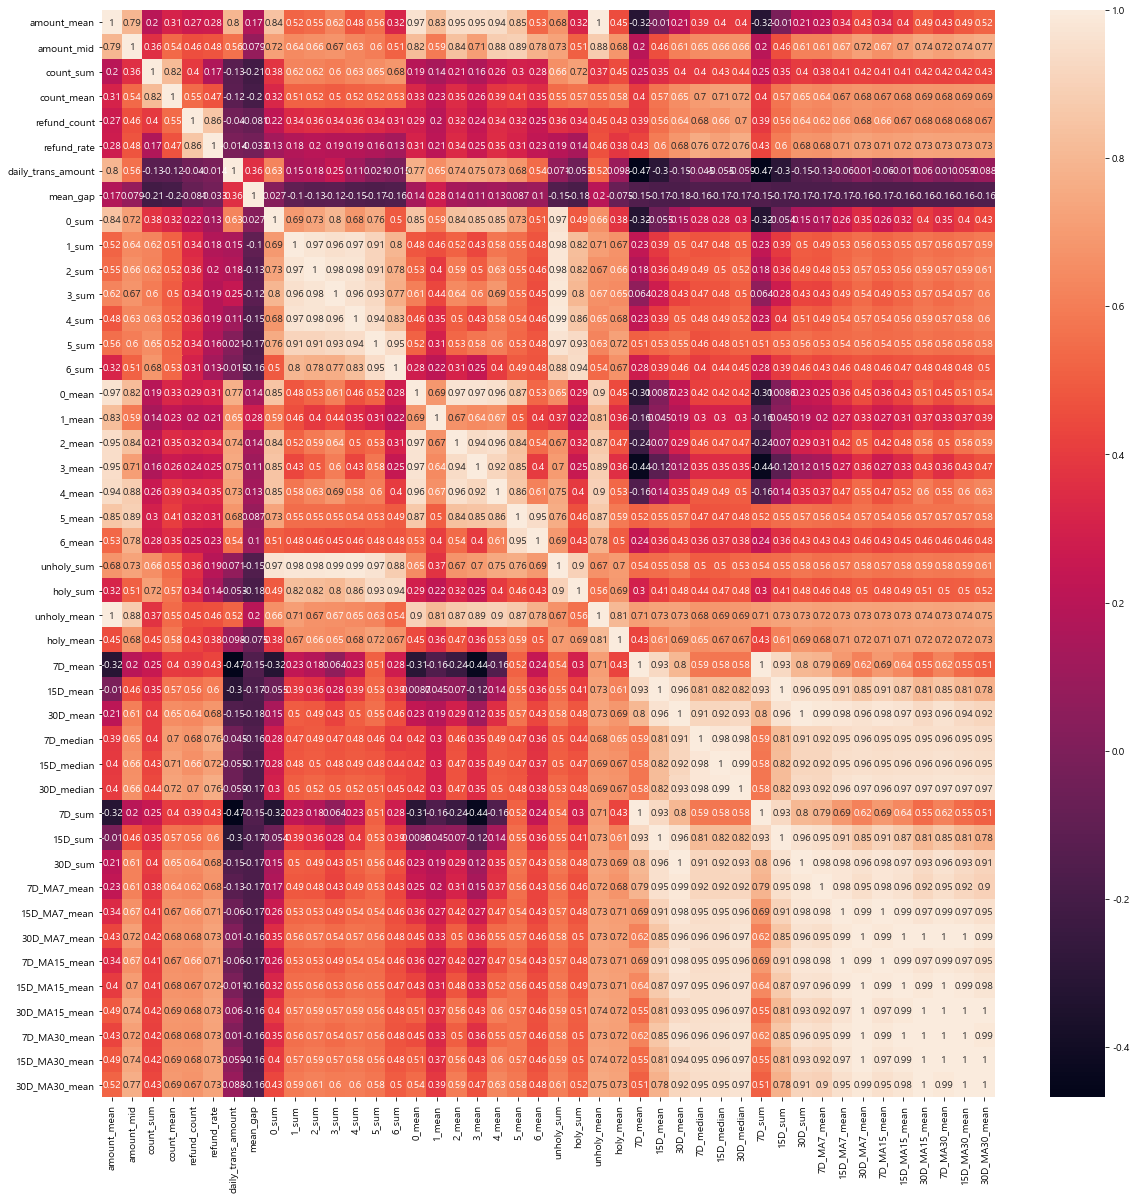

In [69]:
plt.figure(figsize = (20,20))
sns.heatmap(train_X.corr(),annot=True)

### modeling
* 2nd 솔루션은 xgb, train_test_split 0.1만

In [56]:
col = [i for i in reform_train.columns if i not in ['store_id','y']]
y = reform_train['y'].values

train_X, test_X, train_y, test_y = train_test_split(reform_train[col],y, test_size=0.3, random_state=4024)

#### lgbm

In [57]:
lgbm = lightgbm.LGBMRegressor(learning_rate=0.001, n_estimators=30000)

lgbm.fit(train_X,train_y,eval_set=[(train_X,train_y),(test_X,test_y)], eval_names=['train','test'],eval_metric='rmse',verbose=100, early_stopping_rounds= 500)

Training until validation scores don't improve for 500 rounds
[100]	train's rmse: 120306	train's l2: 1.44734e+10	test's rmse: 58467.5	test's l2: 3.41844e+09
[200]	train's rmse: 114648	train's l2: 1.31443e+10	test's rmse: 52425.7	test's l2: 2.74845e+09
[300]	train's rmse: 109767	train's l2: 1.20489e+10	test's rmse: 47155.3	test's l2: 2.22362e+09
[400]	train's rmse: 105562	train's l2: 1.11433e+10	test's rmse: 42621.2	test's l2: 1.81656e+09
[500]	train's rmse: 101942	train's l2: 1.03921e+10	test's rmse: 38707.8	test's l2: 1.49829e+09
[600]	train's rmse: 98834.1	train's l2: 9.76817e+09	test's rmse: 35390.5	test's l2: 1.25248e+09
[700]	train's rmse: 96164	train's l2: 9.24751e+09	test's rmse: 32688.1	test's l2: 1.06851e+09
[800]	train's rmse: 93876.3	train's l2: 8.81276e+09	test's rmse: 30556.1	test's l2: 9.33674e+08
[900]	train's rmse: 91910.9	train's l2: 8.44761e+09	test's rmse: 28973.9	test's l2: 8.39487e+08
[1000]	train's rmse: 90189.7	train's l2: 8.13418e+09	test's rmse: 27730	test's l2

LGBMRegressor(learning_rate=0.001, n_estimators=30000)

In [58]:
y_pred = lgbm.predict(test_X)
score = np.sqrt(mean_squared_error(test_y, y_pred))

In [59]:
y_pred = lgbm.predict(reform_test[col])

In [60]:
submission['total_sales'] = y_pred

today = datetime.datetime.today().date()
os.makedirs('./submission/',exist_ok=True)
submission.to_csv(f'./submission/submission_{today}_lgbm_{score}_rmse.csv',index=False)

#### xgb

In [61]:
def XGB_regressor(train_X, train_y, test_X, test_y, metric, feature_name = None, seed_val = 2018, num_rounds = 3000):
    params = {'objective' : 'reg:squarederror',
              'learning_rate' : 0.05,
              'max_depth' : 10,
              'eval_metric': metric,#??? rmse가 아니고??
              'min_child_weight': 1,
              'subsample': 0.7,
              'colsample_bytree' : 0.7,
              'seed': seed_val}
    plst = list(params.items())
    
    xgtrain = xgb.DMatrix(train_X, label = train_y)
    
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label = test_y)
        watchlist = [ (xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds= 300,verbose_eval= 100)
    else :
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    return model

In [62]:
model = XGB_regressor(train_X, train_y, test_X, test_y, 'rmse')

[0]	train-rmse:135568.93750	test-rmse:81253.84375
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 300 rounds.
[100]	train-rmse:12481.78320	test-rmse:22599.12695
[200]	train-rmse:2665.08374	test-rmse:22745.06641
[300]	train-rmse:760.40314	test-rmse:22738.46484
Stopping. Best iteration:
[99]	train-rmse:12765.96191	test-rmse:22585.57812



In [101]:
y_pred = model.predict(xgb.DMatrix(test_X))
score = np.sqrt(mean_squared_error(test_y, y_pred))
score

22744.927654682284

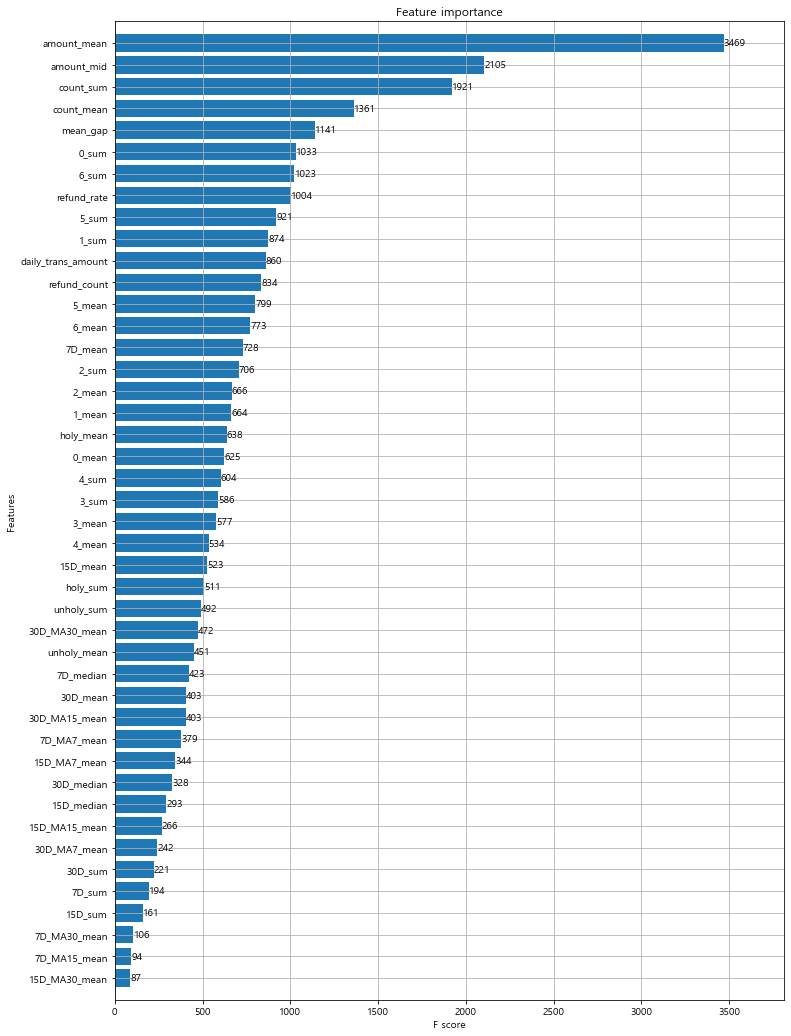

In [65]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [105]:
#몇가지 조정을 더 거친후 제출할 답변임
y_pred = model.predict(xgb.DMatrix(reform_test[col]), ntree_limit = model.best_ntree_limit)

In [104]:
submission['total_sales'] = y_pred

today = datetime.datetime.today().date()
os.makedirs('./submission/',exist_ok=True)
submission.to_csv(f'./submission/submission_{today}_xgb_{score}_rmse.csv',index=False)

ValueError: Length of values does not match length of index

### 솔루션에 있는 조정법 적용

In [106]:
test_adj = test.groupby(['date','store_id']).agg({'amount':'sum'}).reset_index()

test_x_store_id = reform_train.iloc[test_X.index]['store_id'].values
train_adj = train[train.store_id.isin(test_x_store_id)].groupby(['date','store_id']).agg({'amount':'sum'}).reset_index()

#### train 선적용
* rmse가 오히려증가

In [96]:
store_id_list = train_adj.store_id.unique()
store_id_list.sort()

feb_march = []
for store_id in store_id_list:
    mini = train_adj[train_adj.store_id == store_id]
    march = mini[mini.date >= datetime.datetime(2018,3,1)]['date'].count()
    feb = mini[mini.date >= datetime.datetime(2018,2,1)]['date'].count() - march 
    feb_march.append((march+feb)/2/31) 

In [103]:
y_pred = model.predict(xgb.DMatrix(test_X))
adj_y_pred= y_pred * feb_march * 0.72
score = np.sqrt(mean_squared_error(test_y, adj_y_pred))
score

64905.01791559336

#### test적용

In [ ]:
y_pred = model.predict(xgb.DMatrix(reform_test[col]), ntree_limit = model.best_ntree_limit)

In [107]:
store_id_list = test_adj.store_id.unique()
store_id_list.sort()

feb_march = []
for store_id in store_id_list:
    mini = test_adj[test_adj.store_id == store_id]
    march = mini[mini.date >= datetime.datetime(2018,3,1)]['date'].count()
    feb = mini[mini.date >= datetime.datetime(2018,2,1)]['date'].count() - march 
    feb_march.append((march+feb)/2/31) 

In [108]:
adj_y_pred= y_pred * feb_march * 0.72

In [109]:
submission['total_sales'] = adj_y_pred

today = datetime.datetime.today().date()
os.makedirs('./submission/',exist_ok=True)
submission.to_csv(f'./submission/submission_{today}_xgb_adj_{score}_rmse.csv',index=False)

#### lgbm (log scale)

In [ ]:
reform_train[money_col] = reform_train[money_col].apply(lambda x : np.log(1+x))

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(reform_train[col],y, test_size=0.3, random_state=4024)

In [ ]:
lgbm = lightgbm.LGBMRegressor(learning_rate=0.001, n_estimators=30000)

lgbm.fit(train_X,train_y,eval_set=[(train_X,train_y),(test_X,test_y)], eval_names=['train','test'],eval_metric='rmse',verbose=100, early_stopping_rounds= 500)

In [ ]:
y_pred = lgbm.predict(test_X)
score = np.sqrt(mean_squared_error(test_y, y_pred))

In [ ]:
y_pred = lgbm.predict(reform_test[col])

In [204]:
submission['total_sales'] = y_pred

today = datetime.datetime.today().date()
os.makedirs('./submission/',exist_ok=True)
submission.to_csv(f'./submission/submission_{today}_lgbm_scale_{score}_rmse.csv',index=False)

### 작업본

In [19]:
clean_train.loc[clean_train.amount <0,'refund'] = 1
sample_df = clean_train.groupby(['date','store_id']).agg({'amount':['sum','count'],'refund':'sum'}).reset_index()
sample_df.columns = ['date','store_id','amount_sum','amount_count','refund_sum']
sample_df['date'] = pd.to_datetime(sample_df['date'])
sample_df['temp_date'] = sample_df['date']

#거래횟수당 평균 거래금액 
sample_df['trans_amount'] = sample_df['amount_sum']/(sample_df['amount_count']-sample_df['refund_sum'])
sample_df['trans_amount'].fillna(0,inplace= True)

#날짜병합
sample_df = pd.merge(sample_df,all_dates)

sample_df.set_index("date",inplace=True)

#### 주별, 주말별 계산 어쩌냐

In [55]:
#weekly
weekly_sum = weekly['weekly_amount_sum']
weekly_sum.index = [f"{index}_sum" for index in weekly['weekly_amount_sum'].index.values]
feat.update(weekly_sum.to_dict())

weekly_count = weekly['weekly_amount_count']
weekly_count.index = [f"{index}_count" for index in weekly['weekly_amount_count'].index.values]
feat.update(weekly_count.to_dict())

#holyday
holyday.index = ['unholy','holy']
holyday_sum = holyday['holyday_amount_sum']
holyday_sum.index = [f"{index}_sum" for index in holyday['holyday_amount_sum'].index.values]
feat.update(holyday_sum.to_dict())

holyday_count = holyday['holyday_amount_count']
holyday_count.index = [f"{index}_count" for index in holyday['holyday_amount_count'].index.values]
feat.update(holyday_count.to_dict())

In [228]:
store_x[store_x.amount_sum>0].shape[0]

1

In [54]:
weekly = store[['days_of_week','amount_sum']].groupby('days_of_week').agg(['sum','count'])
weekly.columns = ['weekly_amount_sum','weekly_amount_count']
weekly_dict = weekly.to_dict()

holyday = store[['holyday','amount_sum']].groupby('holyday').agg(['sum','count'])
holyday.columns = ['holyday_amount_sum','holyday_amount_count']
holyday_dict = holyday.to_dict()

In [230]:
store_x

,store_id,amount_sum,amount_count,refund_sum,temp_date,trans_amount,days_of_week,holyday,MA7,MA15,MA30
date,,,,,,,,,,,
2018-04-21,1163,545,1,0.0,2018-04-21,545.0,5,0,545.0,545.0,545.0
2018-04-22,1163,0,0,0.0,2018-04-22,0.0,0,0,272.5,272.5,272.5


In [188]:
store

,store_id,amount_sum,amount_count,refund_sum,temp_date,days_of_week,holyday,trans_amount,MA7,MA15,MA30


In [189]:
store = sample_df[sample_df.store_id == 8]

In [164]:
store = sample_df[sample_df.store_id == store_id]

In [174]:
store.trans_amount.sum()

65714.6097208347

In [173]:
store[store.trans_amount>0].shape[0]

531

In [151]:
store = store.asfreq('D',fill_value = 0)

In [152]:
store['temp_date'] = store.index
store['store_id'] = store_id

In [153]:
store

,store_id,amount_sum,amount_count,refund_sum,temp_date
date,,,,,
2016-08-10,32,140,1,0.0,2016-08-10
2016-08-11,32,0,0,0.0,2016-08-11
2016-08-12,32,0,0,0.0,2016-08-12
2016-08-13,32,60,1,0.0,2016-08-13
2016-08-14,32,0,0,0.0,2016-08-14
...,...,...,...,...,...
2018-07-26,32,884,4,0.0,2018-07-26
2018-07-27,32,549,5,0.0,2018-07-27
2018-07-28,32,709,4,0.0,2018-07-28


In [83]:
store_y = store.last("100D")

In [85]:
store_y.amount_sum.sum()

510